In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import seaborn as sn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# load data

mdro = pd.read_excel(r'C:\Users\User\VSCode\智抗菌平台報表_20220309.xlsx', sheet_name='MDROs', 
                        dtype={'病歷號碼':'str', '申請編號':'int', '就醫序號':'int'})
report = pd.read_excel(r'C:\Users\User\VSCode\智抗菌平台報表_20220309.xlsx', sheet_name='微生物報告', 
                        dtype={'病歷號碼':'str', '申請編號':'int', '就醫序號':'int'})
info = pd.read_excel(r'C:\Users\User\VSCode\智抗菌平台報表_20220309.xlsx', sheet_name='就醫資訊', 
                        dtype={'病歷號碼':'str', '就醫序號':'int'})
anti = pd.read_excel(r'C:\Users\User\VSCode\智抗菌平台報表_20220309.xlsx', sheet_name='抗生素使用', 
                        dtype={'病歷號碼':'str', '就醫序號':'int'})
examValue = pd.read_excel(r'C:\Users\User\VSCode\智抗菌平台報表_20220309.xlsx', sheet_name='檢驗數值', 
                        dtype={'病歷號碼':'str', '就醫序號':'int'})



In [4]:
# load data 2021
report2021 = pd.read_excel(r'C:\Users\User\VSCode\data_2021.xlsx', sheet_name='微生物報告', 
                        dtype={'病歷號碼':'str', '申請編號':'int', '就醫序號':'int'})

CMT250 = pd.read_excel(r'C:\Users\User\VSCode\data_2021.xlsx', sheet_name='CMT250', 
                        dtype={'病歷號':'str', '申請編號':'int', '就醫序號':'int'})

examValue2021 = pd.read_excel(r'C:\Users\User\VSCode\data_2021.xlsx', sheet_name='檢驗數值', 
                        dtype={'病歷號碼':'str', '申請編號':'int', '就醫序號':'int'})



In [5]:
mdro = mdro[['病歷號碼', 'time', '就醫序號','申請編號', '菌株', '預測值', '部位', 'sendTime']]
mdro.rename({'time':'openTime'}, axis=1, inplace=True)

In [6]:
report = report[['病歷號碼', 'bed', '就醫序號','申請編號', 'strain','部位', '抗藥性菌株', 'examTime','reportTime']]

In [7]:
cdss = pd.merge(report, mdro, how='left', on=['病歷號碼', '就醫序號','申請編號', '部位'])
cdss = cdss.drop_duplicates()
cdss['minTime'] = cdss.groupby(['病歷號碼', 'bed','就醫序號', '申請編號', '部位', '菌株', '預測值',  'sendTime'])['openTime'].transform('min')

In [8]:
info = info[['病歷號碼', '就醫序號', '性別', '生日', '年齡', '來院日期', '離院日期', '天數', '門急住', '科別代碼', '科別']]
info.rename({'門急住':'bed'}, axis=1, inplace=True)

In [9]:
cdss_info = pd.merge(cdss, info, how='left', on=['病歷號碼', '就醫序號', 'bed'])
cdss_info = cdss_info.drop_duplicates()

In [10]:
CDSS = pd.merge(cdss_info, anti, how='left', on=['病歷號碼','就醫序號'])
CDSS = CDSS.drop_duplicates()

In [11]:
# CDSS.to_excel(r'C:\Users\User\VSCode\CDSS(2022).xlsx')

In [12]:
# evaluation

m = CDSS[CDSS.openTime==CDSS.minTime]

In [13]:
# Staphylococcus aureus

SA = m[(m['菌株'] == 'Staphylococcus aureus')|(m['菌株'] == 'Staphylococcus aureus(MRSA)')]
SA = SA.drop_duplicates() 

SA = SA[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', '年齡', '抗藥性菌株', 'examTime',
       'reportTime', 'openTime', '菌株', '預測值', 'sendTime']].drop_duplicates() #101
SA['STRAIN'] = 'Staphylococcus aureus'

# add column 'predValue interval'
condition = [(SA['預測值'] <= 20), (SA['預測值'] > 20)&(SA['預測值'] <= 40), 
             (SA['預測值'] > 40)&(SA['預測值'] <= 60), (SA['預測值'] > 60)&(SA['預測值'] <= 80),
             (SA['預測值'] > 80)&(SA['預測值'] <= 100)]

value = ['0~20%', '21~40%', '41~60%', '61~80%', '81~100%']
SA['PredLevel'] = np.select(condition, value)

# add column 'Resistance'
SA['Resist'] = np.where(SA['抗藥性菌株']==1, 'MRSA', 'MSSA')
SA.rename({'年齡':'Age', '預測值':'PredValue'}, axis=1, inplace=True)


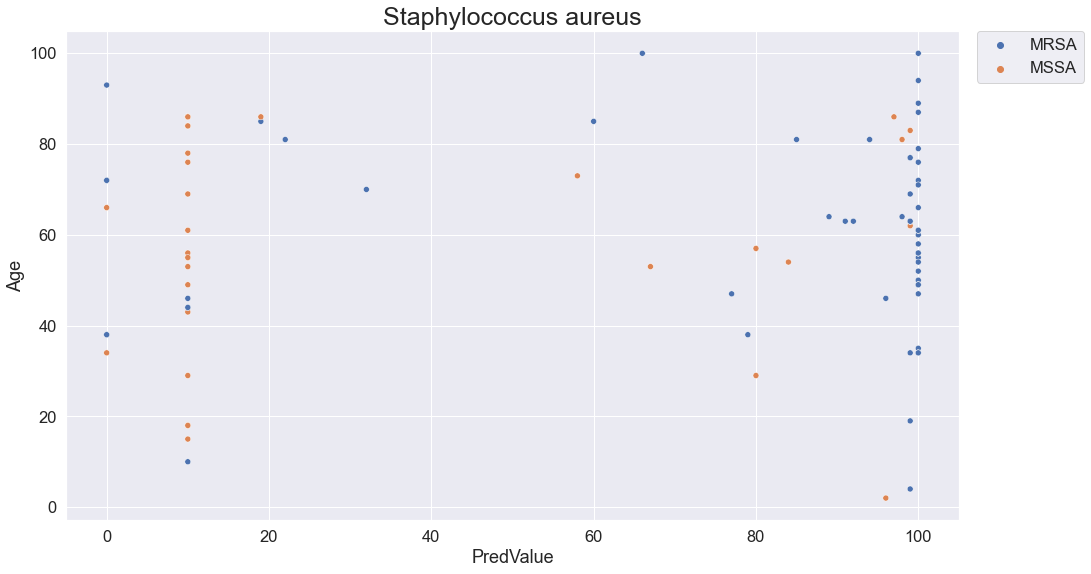

In [14]:
# scatter plot

plt.figure(figsize=(16, 9))
sn.set(font_scale = 1.5)
plt.title('Staphylococcus aureus', fontsize = 25)

ax = sn.scatterplot(data=SA, x="PredValue", y="Age", hue="Resist")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.legend(loc='upper right')
# sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

plt.show()

In [15]:
print(SA.groupby('PredLevel')['Resist'].value_counts().sort_index())
SA.groupby('PredLevel')['PredValue'].describe()

PredLevel  Resist
0~20%      MRSA      11
           MSSA      24
21~40%     MRSA       2
41~60%     MRSA       1
           MSSA       1
61~80%     MRSA       3
           MSSA       3
81~100%    MRSA      50
           MSSA       6
Name: Resist, dtype: int64


,count,mean,std,min,25%,50%,75%,max
PredLevel,,,,,,,,
0~20%,35.0,8.514286,4.804235,0.0,10.0,10.0,10.00,19.0
21~40%,2.0,27.000000,7.071068,22.0,24.5,27.0,29.50,32.0
41~60%,2.0,59.000000,1.414214,58.0,58.5,59.0,59.50,60.0
61~80%,6.0,74.833333,6.554896,66.0,69.5,78.0,79.75,80.0
81~100%,56.0,98.232143,3.582742,84.0,99.0,100.0,100.00,100.0


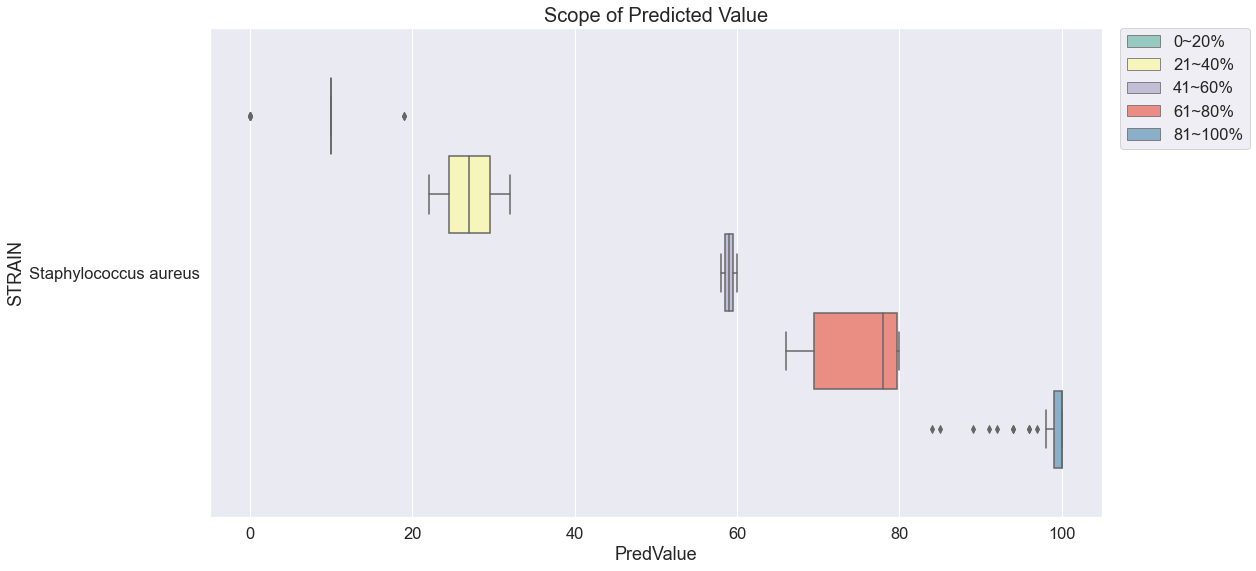

In [16]:
plt.figure(figsize=(16,9))

hue_order = ['0~20%', '21~40%', '41~60%', '61~80%', '81~100%']
sn.boxplot(y='STRAIN', x='PredValue', orient='h', data=SA, hue='PredLevel', hue_order=hue_order, palette="Set3")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.title('Scope of Predicted Value', fontsize = 20)
plt.show()

In [17]:


# C_pred = [(SA['菌株'] == 'Staphylo
# coccus aureus'), (SA['菌株'] == 'Staphylococcus aureus(MRSA)')]
# V_pred = ['MSSA', 'MRSA']

# C_act = [(SA['抗藥性菌株']!=1), (SA['抗藥性菌株']==1)]
# V_act = ['MSSA', 'MRSA']

# SA['SA_pred'] = np.select(C_pred, V_pred)
# SA['SA_actual'] = np.select(C_act, V_act)
# SA['Group'] = 'Staphylococcus aureus'
# SA.head() 

SA['Predicted'] = np.where(SA['PredLevel'] != '81~100%', 'MSSA', 'MRSA')
# SA['Actual'] = np.where(SA['Resist'] == 'MRSA', 1, 0) 


Predicted  MRSA  MSSA
Actual               
MRSA         50    17
MSSA          6    28


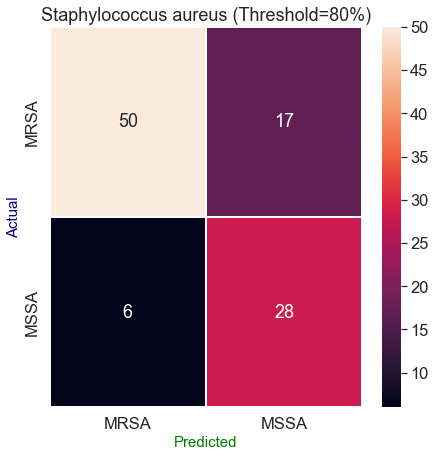

In [27]:
# confusion matrix

confusion_matrix_SA = pd.crosstab(SA['Resist'], SA['Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix_SA)


plt.figure(figsize=(7,7))
sn.set(font_scale = 1.5)
sn.heatmap(confusion_matrix_SA, annot=True, fmt='d', linewidths=1.5)
plt.title('Staphylococcus aureus (Threshold=80%)', fontsize = 18)
plt.xlabel('Predicted', fontsize = 15, color='green')
plt.ylabel('Actual', fontsize = 15, color='navy')
plt.show()

In [19]:
# box plot (pred value range)

# SA_1 = SA[(SA.SA_pred=='True')&(SA.SA_actual=='True')][['菌株', '預測值', 'Group']]
# SA_0 = SA[(SA.SA_pred!='True')&(SA.SA_actual!='True')][['菌株', '預測值', 'Group']]
# SA_1_0 = pd.concat([SA_1, SA_0])
# SA_1_0.rename({'菌株':'strain', '預測值':'pred_value'}, axis=1, inplace=True)

# SA_1_0.groupby('strain').describe()

In [20]:
# plt.figure(figsize=(6,4))
# sn.boxplot(y='strain', x='pred_value', orient='h', data=SA_1_0, palette="Set3")
# plt.title('Scope of Predicted Value', fontsize = 15)
# plt.show()

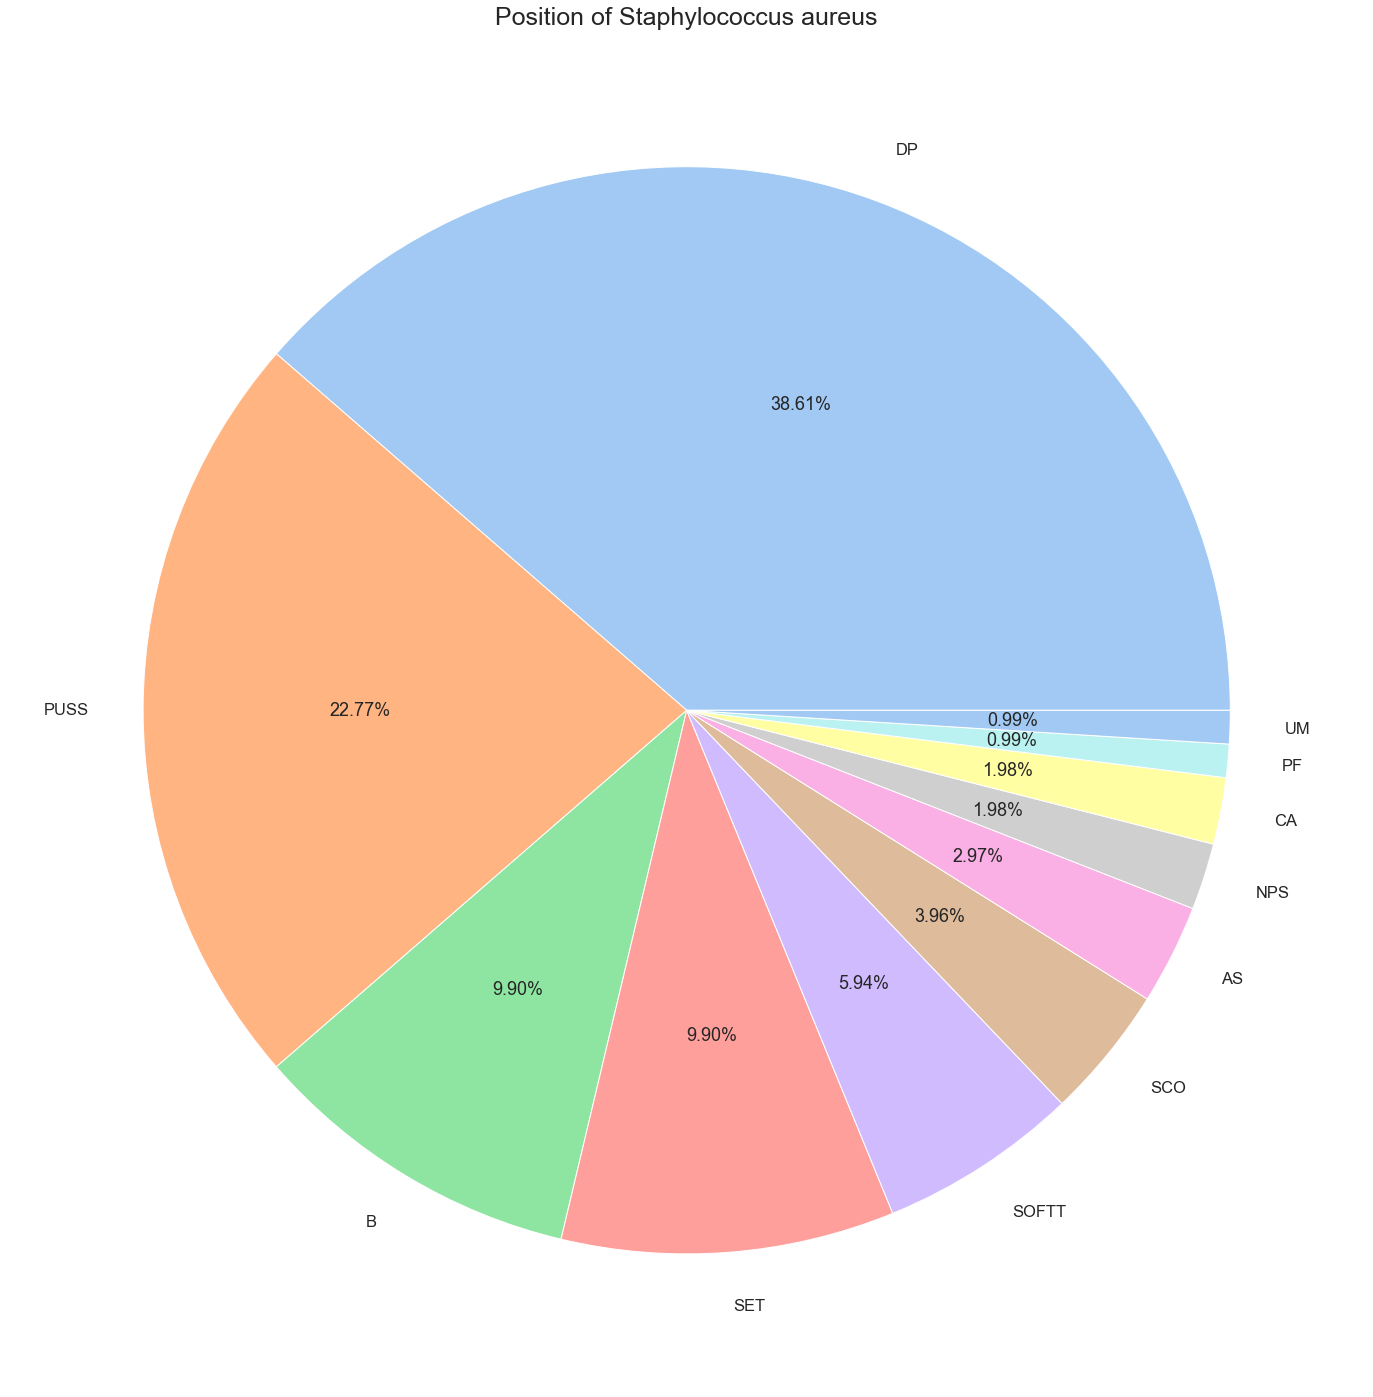

In [21]:
pieData = SA['部位'].value_counts()
label = pieData.index

colors = sn.color_palette('pastel')

#create pie chart
sn.set(font_scale = 1.5)
plt.figure(figsize=(25,25))
plt.pie(pieData, labels = label, autopct='%.2f%%', colors=colors)
plt.title('Position of Staphylococcus aureus', fontsize = 25)
plt.show()

In [22]:
# SA.SA_actual.value_counts()
# sn.histplot(data=SA, x=SA.SA_pred)

In [23]:
# SA.SA_pred

his_1 = pd.DataFrame({'strain_pred':SA.SA_pred, 'strain_actual':SA.SA_actual})
his_2 = pd.DataFrame({'strain':SA.SA_actual, 'type':'actual'})

In [24]:
# his = pd.concat([his_1, his_2])
# # his
# his = his.reset_index(drop=True)

# sn.histplot(data=his_1, x='strain_pred')

In [25]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 7))
# fig.suptitle('Staphylococcus aureus', fontsize = 25)

# # predicted
# sn.histplot(data=his_1, x='strain_pred', color="gold", ax=axs[0])
# axs[0].set_title('Predicted', fontsize = 15)

# # actual
# sn.histplot(data=his_1, x='strain_actual', color='teal',ax=axs[1])
# axs[1].set_title('Actual', fontsize = 15)
# plt.show()

NameError: name 'his_1' is not defined

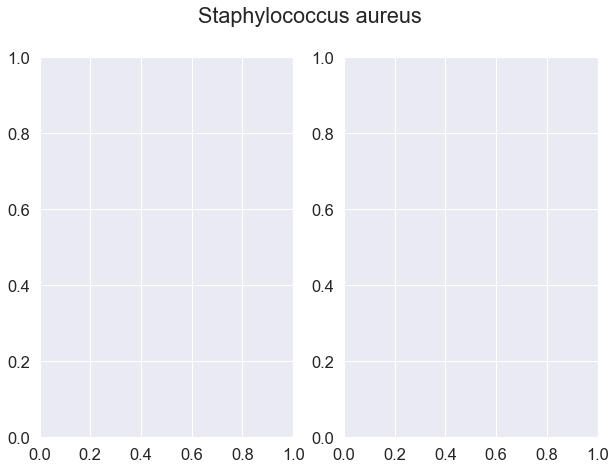

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))
fig.suptitle('Staphylococcus aureus')

order_list = ['SA', 'MRSA']

pred = sn.barplot(x=his_1.strain_pred.value_counts().index, y=his_1.strain_pred.value_counts() ,color="gold", ax=axs[0], order=order_list, alpha  = 0.6)
pred.bar_label(pred.containers[0])
axs[0].set_title('Predicted')

actual = sn.barplot(x=his_1.strain_actual.value_counts().index, y=his_1.strain_actual.value_counts() ,color="teal", ax=axs[1], order=order_list, alpha  = 0.6)
actual.bar_label(actual.containers[0])
axs[1].set_title('Actual')

plt.show()

In [ ]:
his_1.strain_actual.value_counts().values

array([604, 162], dtype=int64)

In [ ]:
his_1.strain_pred.value_counts()

SA      603
MRSA    163
Name: strain_pred, dtype: int64

In [ ]:
m['病歷號碼'].drop_duplicates()

20762    0036984922
20798    0011798993
21097    0017896571
21278    0037886792
21406    0037957068
            ...    
64845    0032813718
65306    0022775498
65390    0037807750
65393    0022091458
65442    0013854513
Name: 病歷號碼, Length: 387, dtype: object

In [ ]:
SA[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', '抗藥性菌株', 'examTime',
       'reportTime', 'openTime', '菌株', '預測值', 'sendTime', 'minTime']].drop_duplicates()

,病歷號碼,bed,就醫序號,申請編號,strain,部位,抗藥性菌株,examTime,reportTime,openTime,菌株,預測值,sendTime,minTime
21278,0037886792,住院,231737615,393924901,[嗜氧] Staphylococcus aureus(MRSA) (Gram Positiv...,SCO,1.0,2021-12-30 13:02,2022-01-04 10:01,2022-01-03 08:50,Staphylococcus aureus(MRSA),0.0,2022-01-01 13:38,2022-01-03 08:50
21286,0037886792,住院,231737615,393924901,[嗜氧] Staphylococcus aureus(MRSA) (Gram Positiv...,SCO,1.0,2021-12-30 13:02,2022-01-04 10:01,2022-01-03 08:23,Staphylococcus aureus,0.0,2022-01-01 13:38,2022-01-03 08:23
21484,0018040913,住院,228842331,393925263,[嗜氧] Staphylococcus aureus(MRSA) (Gram Positiv...,PUSS,1.0,2021-12-31 10:09,2022-01-04 10:56,2022-01-02 11:18,Staphylococcus aureus,0.0,2022-01-02 08:09,2022-01-02 11:18
21568,0027582201,住院,232121985,393925403,[嗜氧] Staphylococcus aureus (Gram Positive Coccus),SCO,NaN,2021-12-31 09:50,2022-01-04 09:49,2022-01-04 08:52,Staphylococcus aureus,0.0,2022-01-02 08:09,2022-01-04 08:52
21763,0033297320,住院,231253802,393925654,[嗜氧] Staphylococcus aureus(MRSA) (Gram Positiv...,DP,1.0,2021-12-31 13:29,2022-01-06 09:23,2022-01-05 10:19,Staphylococcus aureus(MRSA),0.0,2022-01-02 08:09,2022-01-05 10:19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63619,0000601908,住院,232540482,393971616,[嗜氧] Staphylococcus aureus (Gram Positive Coccus),SET,NaN,2022-03-07 09:49,2022-03-08 13:56,2022-03-09 09:01,Staphylococcus aureus,99.0,2022-03-08 14:06,2022-03-09 09:01
64387,0038077841,住院,232628077,393972663,[嗜氧] Staphylococcus aureus(MRSA) (Gram Positiv...,DP,1.0,2022-03-05 13:44,2022-03-09 11:26,2022-03-08 00:22,Staphylococcus aureus,10.0,2022-03-07 14:46,2022-03-08 00:22
64652,0031702069,住院,232987292,393973244,[血液] Staphylococcus aureus (Gram Positive Coccus),B,NaN,2022-03-07 08:15,2022-03-09 08:28,2022-03-08 10:22,Staphylococcus aureus,84.0,2022-03-08 09:46,2022-03-08 10:22
64820,0029065756,住院,233001876,393973566,[嗜氧] Staphylococcus aureus(MRSA) (Gram Positiv...,PUSS,1.0,2022-03-07 09:46,2022-03-09 11:26,2022-03-09 10:45,Staphylococcus aureus(MRSA),10.0,2022-03-08 13:46,2022-03-09 10:45


In [ ]:
SA.病歷號碼.drop_duplicates()

21278    0037886792
21484    0018040913
21568    0027582201
21763    0033297320
22335    0037461050
            ...    
62893    0033506463
63619    0000601908
64652    0031702069
64820    0029065756
65393    0022091458
Name: 病歷號碼, Length: 67, dtype: object

In [ ]:
SA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 21278 to 65393
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   病歷號碼        101 non-null    object 
 1   bed         101 non-null    object 
 2   就醫序號        101 non-null    int32  
 3   申請編號        101 non-null    int32  
 4   strain      101 non-null    object 
 5   部位          101 non-null    object 
 6   抗藥性菌株       67 non-null     float64
 7   examTime    101 non-null    object 
 8   reportTime  101 non-null    object 
 9   openTime    101 non-null    object 
 10  菌株          101 non-null    object 
 11  預測值         101 non-null    float64
 12  sendTime    101 non-null    object 
 13  minTime     101 non-null    object 
 14  SA_pred     101 non-null    object 
 15  SA_actual   101 non-null    object 
 16  Group       101 non-null    object 
dtypes: float64(2), int32(2), object(13)
memory usage: 13.4+ KB


In [ ]:
cdss[cdss.openTime==cdss.minTime]

,病歷號碼,bed,就醫序號,申請編號,strain,部位,抗藥性菌株,examTime,reportTime,openTime,菌株,預測值,sendTime,minTime
6022,0036984922,住院,232088191,393923849,[嗜氧] Enterococcus faecium(VRE) (Gram Positive ...,AS,1.0,2021-12-29 09:01,2022-01-06 15:18,2022-01-03 14:34,Enterococcus faecium(VRE),100.0,2021-12-30 13:13,2022-01-03 14:34
6031,0011798993,住院,232061188,393923961,[嗜氧] Klebsiella oxytoca (Gram Negative Bacilli...,DP,1.0,2021-12-29 14:31,2022-01-04 09:16,2022-01-03 08:35,Klebsiella pneumoniae,10.0,2022-01-02 08:09,2022-01-03 08:35
6088,0017896571,住院,232117062,393924547,[嗜氧] Escherichia coli (Gram Negative Bacilli),UC,NaN,2021-12-30 08:54,2022-01-03 11:01,2022-01-03 08:26,Escherichia coli,10.0,2021-12-31 13:43,2022-01-03 08:26
6116,0037886792,住院,231737615,393924901,[嗜氧] Staphylococcus aureus(MRSA) (Gram Positiv...,SCO,1.0,2021-12-30 13:02,2022-01-04 10:01,2022-01-03 08:50,Staphylococcus aureus(MRSA),0.0,2022-01-01 13:38,2022-01-03 08:50
6117,0037886792,住院,231737615,393924901,[嗜氧] Staphylococcus aureus(MRSA) (Gram Positiv...,SCO,1.0,2021-12-30 13:02,2022-01-04 10:01,2022-01-03 08:23,Staphylococcus aureus,0.0,2022-01-01 13:38,2022-01-03 08:23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14255,0022775498,住院,232328355,393974304,[嗜氧] Enterococcus faecium (Gram Positive Coccu...,BI,NaN,2022-03-08 08:33,2022-03-09 14:26,2022-03-09 15:33,Pseudomonas aeruginosa,10.0,2022-03-09 14:46,2022-03-09 15:33
14274,0037807750,住院,233006514,393974458,[嗜氧] Klebsiella pneumoniae (Gram Negative Baci...,UC,NaN,2022-03-08 14:46,2022-03-09 14:18,2022-03-09 16:19,Klebsiella pneumoniae,31.0,2022-03-09 14:36,2022-03-09 16:19
14275,0022091458,住院,232992212,393974463,[嗜氧] Staphylococcus aureus (Gram Positive Coccus),PUSS,NaN,2022-03-08 10:43,2022-03-09 14:42,2022-03-09 15:01,Staphylococcus aureus,10.0,2022-03-09 14:56,2022-03-09 15:01
14293,0013854513,住院,232877378,393974762,[嗜氧] Acinetobacter baumannii (Gram Negative Co...,DP,NaN,2022-03-08 14:48,2022-03-09 14:34,2022-03-09 15:53,Acinetobacter baumannii,10.0,2022-03-09 14:56,2022-03-09 15:53


In [ ]:
cdss[cdss.openTime==cdss.minTime]['病歷號碼'].drop_duplicates()

6022     0036984922
6031     0011798993
6088     0017896571
6116     0037886792
6130     0037957068
            ...    
14153    0032813718
14254    0022775498
14274    0037807750
14275    0022091458
14293    0013854513
Name: 病歷號碼, Length: 387, dtype: object

In [ ]:
print(CDSS.info())

CDSS['病歷號碼'].drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65327 entries, 0 to 65498
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   病歷號碼        65327 non-null  object 
 1   bed         65327 non-null  object 
 2   就醫序號        65327 non-null  int32  
 3   申請編號        65327 non-null  int32  
 4   strain      59079 non-null  object 
 5   部位          65327 non-null  object 
 6   抗藥性菌株       21696 non-null  float64
 7   examTime    65327 non-null  object 
 8   reportTime  65327 non-null  object 
 9   openTime    14680 non-null  object 
 10  菌株          14680 non-null  object 
 11  預測值         14680 non-null  float64
 12  sendTime    13476 non-null  object 
 13  minTime     13476 non-null  object 
 14  性別          59070 non-null  object 
 15  生日          59070 non-null  object 
 16  來院日期        59070 non-null  object 
 17  離院日期        38927 non-null  object 
 18  天數          59070 non-null  float64
 19  科別代碼        59070 non-nul

0        0016832410
1        0000744016
2        0000347929
3        0016247817
4        0014370701
            ...    
65435    0026449048
65438    0000466667
65481    0033841687
65483    0035484292
65498    0000736229
Name: 病歷號碼, Length: 4020, dtype: object

In [ ]:
examValue

,病歷號碼,就醫序號,檢驗日期,報告日期,WBC,CRE,GFR,ALT,T-bil,hsCRP,ESR
0,0031795531,161572515,2020-06-19 06:56,2020-06-19 07:16,7,NaN,NaN,NaN,NaN,NaN,NaN
1,0031795531,161572515,2020-06-20 23:21,2020-06-20 23:30,9.6,NaN,NaN,NaN,NaN,NaN,NaN
2,0031795531,161572515,2020-06-21 01:47,2020-06-21 02:09,NaN,NaN,NaN,13,NaN,NaN,NaN
3,0031795531,161572515,2020-06-21 01:47,2020-06-21 02:09,NaN,NaN,NaN,NaN,1.85,NaN,NaN
4,0031795531,161572515,2020-06-21 01:47,2020-06-21 02:09,NaN,1.96,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
112644,0038168704,233061240,2022-03-09 23:07,2999-12-31 00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112645,0038168704,233061240,2022-03-09 23:07,2999-12-31 00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112646,0038168704,233061240,2022-03-09 23:07,2999-12-31 00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112647,0038168704,233061240,2022-03-09 23:07,2999-12-31 00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
